# Easy Money - Modelo de propensión a compra

Mensaje de Carol: Una vez que hayamos hecho el análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a comprar nuestros productos así que te pido por favor hagas un modelo de propensión a compra, se que tenemos muchos productos, así que te dejo a tu criterio científico qué productos elegir, o pueden ser varios, ya me sorprenderás

Vamos a desarrollar un modelo capaz de **predecir si un cliente es propenso a contratar un producto de Easy Money, teniendo en cuenta sus características**.

## Importación de librerías

In [234]:
# Importamos las librerias necesarias.
import os
import pandas as pd
import numpy as np


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
from sklearn import model_selection 
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns

## Importación de datos

De las tablas que tenemos disponibles en BBDD, las que serán de utilidad para este modelo son customer_sociodemographics, customer_commercial_activity y sales. 
<p>Guardamos los datos de las tablas en dataframes distintos que limpiaremos, y posteriormente uniremos en un único dataframe 


In [236]:
# Obtener el directorio de trabajo actual
current_dir = os.getcwd()

# Ir a la carpeta anterior del directorio actual porque ahí se encuentra la carpeta 'data' donde están todos los ficheros .csv
parent_dir = os.path.dirname(current_dir)

DATA_PATH = os.path.join(parent_dir, 'data/') # Ruta donde están los ficheros .csv

FILE_NAME1 = 'customer_sociodemographics.csv'
FILE1 = os.path.join(DATA_PATH, FILE_NAME1)

FILE_NAME2 = 'customer_commercial_activity.csv'
FILE2 = os.path.join(DATA_PATH, FILE_NAME2)

FILE_NAME3 = 'sales.csv'
FILE3 = os.path.join(DATA_PATH, FILE_NAME3)

FILE_NAME4 = 'customer_products.csv'
FILE4 = os.path.join(DATA_PATH, FILE_NAME4)

print('current path:', current_dir)
print('parent path:', parent_dir)
print('data path:', DATA_PATH)
print('file 1:', FILE1)
print('file 2:', FILE2)
print('file 3:', FILE3)
print('file 4:', FILE4)
print('data path:', DATA_PATH)

current path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/clustering
parent path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/
file 1: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_sociodemographics.csv
file 2: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_commercial_activity.csv
file 3: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/sales.csv
file 4: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_products.csv
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/


In [237]:
df_cs = pd.read_csv(FILE1, index_col=0)
df_cca = pd.read_csv(FILE2, index_col=0)
df_sales = pd.read_csv(FILE3, index_col=0)
df_customer_products = pd.read_csv(FILE4, index_col=0)

## 1: Data Understanding

### 1.1: Análisis Univariante de datos de las distintos datasets que vamos a usar

#### 1.1.1 Analizamos la tabla customer_sociodemographics

In [238]:
# Datos generales 

df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pk_cid        int64  
 1   pk_partition  object 
 2   country_id    object 
 3   region_code   float64
 4   gender        object 
 5   age           int64  
 6   deceased      object 
 7   salary        float64
dtypes: float64(2), int64(2), object(4)
memory usage: 409.4+ MB


In [239]:
# Visualización de los datos
df_cs.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [240]:
# Recuento de nulos 

df_cs.isna().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

De entrada, analizamos la columna "deceased" para eliminar los clientes fallecidos y quedarnos con aquellos que actualmente son reales

In [241]:
df_cs['deceased'].value_counts()

deceased
N    5961849
S       1075
Name: count, dtype: int64

In [242]:
df_cs = df_cs[(df_cs['deceased']  == 'N')]
df_cs['deceased'].value_counts()

deceased
N    5961849
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes no fallecidos, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [243]:
del(df_cs['deceased'])

Analizamos también la columna country_id para ver si vale la pena quedarnos con todos los países de la BBDD 

In [244]:
df_cs['country_id'].value_counts()

country_id
ES    5959602
GB        441
FR        225
DE        199
US        195
CH        189
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: count, dtype: int64

Vemos que los valores de los países distintos a ES son muy pequeños y no aportarán demasiado valor a nuestro modelo. Nos quedamos solamente con los registros que son country_id = ES

In [245]:
df_cs = df_cs[(df_cs['country_id']  == 'ES')]
df_cs['country_id'].value_counts()

country_id
ES    5959602
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes de ES, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [246]:
del(df_cs['country_id'])

Según el diccionario de las tablas, region_code es el código de provincia. Este dato sí puede ser relevante, pero vemos que tiene nulos. Como estamos ante un modelo de clasificación binaria, podemos rellenar los nulos con un valor como -1, para que se sean agrupados en un bloque propio.

In [247]:
df_cs['region_code'].fillna(-1, inplace=True)

La columna gender también tenía nulos, pero son muy pocos en relación al total del dataset. Analizamos cuántos nulos quedan después de los cambios ya realizados y elimnamos estas filas por ser muy pocas

In [248]:
df_cs['gender'].isna().sum()

25

In [249]:
df_cs = df_cs.dropna(subset =['gender'])

Analizamos la columna salary 

In [250]:
df_cs['salary'].value_counts()

salary
451931.22    709
288997.44    546
135522.15    466
128318.52    458
104563.80    436
            ... 
127111.23      1
100303.05      1
125135.46      1
188185.68      1
167276.64      1
Name: count, Length: 257626, dtype: int64

In [251]:
df_cs['salary'].describe()

count    4.420911e+06
mean     1.155810e+05
std      2.000189e+05
min      1.202730e+03
25%      6.141354e+04
50%      8.843742e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64

Vemos que todos los valores son positivos, que la diferencia entre el salario mayor y el salario menor es muy grande, y que la media por tanto es muy elevada también. Igualmente, según el diccionario de la BBDD, se trata del salario de la unidad familiar y consideramos que este valor es importante a la hora de determinar la contratación. Al haber muchos nulos, y al ser el modelo de clasificación binaria, vamos a asignar a los nulos el valor -1

In [252]:
df_cs['salary'].fillna(-1, inplace=True)

Transformamos la columna region_code de float a int

In [253]:
df_cs["region_code"] = df_cs["region_code"].astype(int)

Transformamos la columna pk_partition a fecha

In [254]:
df_cs["pk_partition"] = pd.to_datetime(df_cs["pk_partition"])


Finalmente, la tabla de customer_sociodemographics quedará así:

In [255]:
df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5959577 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   pk_cid        int64         
 1   pk_partition  datetime64[ns]
 2   region_code   int64         
 3   gender        object        
 4   age           int64         
 5   salary        float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 318.3+ MB


#### 1.1.2 Analizamos la tabla customer_commercial_activity

In [256]:
# Datos generales 

df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   pk_cid           int64  
 1   pk_partition     object 
 2   entry_date       object 
 3   entry_channel    object 
 4   active_customer  float64
 5   segment          object 
dtypes: float64(1), int64(1), object(4)
memory usage: 318.5+ MB


In [257]:
# Visualización de los datos
df_cca.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [258]:
# Recuento de nulos 

df_cca.isna().sum()

pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [259]:
pd.set_option('display.max_rows', 100)

In [260]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE    53.413469
KFC    15.276786
KHQ    10.125061
KAT     7.137080
KHK     3.948564
KHM     3.029062
KHN     1.859966
KFA     1.355428
KHD     1.301894
RED     1.039488
KHL     0.715897
KHF     0.354329
KHO     0.141461
KAZ     0.096657
KHC     0.089899
KBG     0.028508
KEH     0.012487
KHP     0.011853
007     0.010515
013     0.006810
KAG     0.005746
KAS     0.005232
KBZ     0.003396
KAA     0.003311
KAR     0.002693
KAY     0.002556
KAF     0.002110
KAB     0.001630
KFD     0.001561
KCC     0.001527
KAW     0.001115
KAQ     0.000892
KDH     0.000875
KAE     0.000823
KCH     0.000823
KCB     0.000806
KAD     0.000772
KAM     0.000738
KAH     0.000686
KAK     0.000583
KAJ     0.000566
KDT     0.000395
KFF     0.000377
KBO     0.000360
KEY     0.000343
KGC     0.000292
004     0.000292
KFS     0.000292
KCL     0.000292
KBE     0.000292
KBH     0.000292
KFK     0.000292
KGN     0.000292
KCI     0.000292
KGX     0.000292
KDR     0.000274
KFL     0.000223
KBW     0.000206


Vemos muchos valores de Entry Channel que son muy pocos en comparación con los valores mayoritarios. Elegimos los canales de entrada que tengan una proporción mayor al 1% y agrupamos el resto en Others

In [261]:
value_counts = (df_cca['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_cca['entry_channel'] = df_cca['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [262]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE       53.413469
KFC       15.276786
KHQ       10.125061
KAT        7.137080
KHK        3.948564
KHM        3.029062
KHN        1.859966
Others     1.513202
KFA        1.355428
KHD        1.301894
RED        1.039488
Name: proportion, dtype: float64

Analizamos la columna segment para ver los valores únicos, sabiendo que también tiene nulos

In [263]:
df_cca['segment'].value_counts()

segment
03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: count, dtype: int64

Rellenamos NaN de channel y segment con un valor identificativo como 'Not defined'

In [264]:
df_cca["entry_channel"].fillna('Not defined', inplace=True)
df_cca["segment"].fillna('Not defined', inplace=True)

In [265]:
df_cca.isna().sum()

pk_cid             0
pk_partition       0
entry_date         0
entry_channel      0
active_customer    0
segment            0
dtype: int64

In [266]:
df_cca['active_customer'].value_counts()

active_customer
0.0    3557573
1.0    2405351
Name: count, dtype: int64

Transformarmos active_customer de float a int

In [267]:
df_cca["active_customer"] = df_cca["active_customer"].astype(int)

Transformamos las columna pk_partition y entry_date a fecha

In [268]:
df_cca["pk_partition"] = pd.to_datetime(df_cca["pk_partition"])
df_cca["entry_date"] = pd.to_datetime(df_cca["entry_date"])

Finalmente, la tabla de customer_commercial_activity quedará así:

In [269]:
df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   pk_cid           int64         
 1   pk_partition     datetime64[ns]
 2   entry_date       datetime64[ns]
 3   entry_channel    object        
 4   active_customer  int64         
 5   segment          object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 318.5+ MB


#### 1.1.3 Analizamos la tabla sales

In [270]:
# Datos generales 

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240773 entries, 0 to 240772
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pk_sale     240773 non-null  int64  
 1   cid         240773 non-null  int64  
 2   month_sale  240773 non-null  object 
 3   product_ID  240773 non-null  int64  
 4   net_margin  240773 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 11.0+ MB


In [271]:
# Visualización de los datos
df_sales.head()

,pk_sale,cid,month_sale,product_ID,net_margin
0,6666,33620,2018-05-01,2335,952.9
1,6667,35063,2018-06-01,2335,1625.2
2,6668,37299,2018-02-01,2335,1279.7
3,6669,39997,2018-02-01,2335,1511.9
4,6670,44012,2018-02-01,2335,1680.3


In [272]:
# Recuento de nulos 

df_sales.isna().sum()

pk_sale       0
cid           0
month_sale    0
product_ID    0
net_margin    0
dtype: int64

La columna pk_sale es el identificador de la venta. Esta columna no va a ser necesaria para el modelo, por lo que la eliminamos.

In [273]:
del(df_sales['pk_sale'])

La clolumna net_margin nos puede ser útil para decidir qué producto elegir para la predicción de nuestro modelo, por lo que de momento la dejamos.

Transformamos la columna month_sale a fecha

In [274]:
df_sales["month_sale"] = pd.to_datetime(df_sales["month_sale"])

Finalmente, la tabla de sales quedará así:

In [275]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240773 entries, 0 to 240772
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cid         240773 non-null  int64         
 1   month_sale  240773 non-null  datetime64[ns]
 2   product_ID  240773 non-null  int64         
 3   net_margin  240773 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 9.2 MB


## 1.4 Analizamos el dataset de customer product

In [276]:
df_customer_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   short_term_deposit  int64  
 3   loans               int64  
 4   mortgage            int64  
 5   funds               int64  
 6   securities          int64  
 7   long_term_deposit   int64  
 8   em_account_pp       int64  
 9   credit_card         int64  
 10  payroll             float64
 11  pension_plan        float64
 12  payroll_account     int64  
 13  emc_account         int64  
 14  debit_card          int64  
 15  em_account_p        int64  
 16  em_acount           int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 818.9+ MB


In [277]:
df_customer_products["pk_partition"] = pd.to_datetime(df_customer_products["pk_partition"] )

In [278]:
df_customer_products.isnull().sum()

pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [279]:
df_customer_products["payroll"]=df_customer_products["payroll"].fillna(0)
df_customer_products[ 'pension_plan']=df_customer_products[ 'pension_plan'].fillna(0)

In [280]:
df_customer_products.isnull().sum()

pk_cid                0
pk_partition          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
em_account_pp         0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
dtype: int64

## 2: Construcción del dataset para el modelo

Vamos a hacer un inner merge de todos los datasets, ya que nos interesa agrupar toda la información analizada en un único dataframe, que contenga toda la información por el id de cliente.

In [281]:
df_merged = pd.merge(
    left = df_cca, 
    right = df_cs,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [282]:
df_merged.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary
0,1375586,2018-01-01,2018-01-01,Others,1,02 - PARTICULARES,29,H,35,87218.10
1,1050611,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74
2,1050612,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11
3,1050613,2018-01-01,2015-08-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54
4,1050614,2018-01-01,2015-08-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00


In [283]:
df_merged2 = pd.merge(
    left = df_merged, 
    right = df_customer_products,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [284]:
pd.set_option('display.max_rows', 1000)

### Limpiamos todas las particiones menos la última 5-2019

In [285]:
df_merged2=df_merged2.loc[df_merged2['pk_partition'] =='2019-05']

In [286]:
df_merged2

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959572,1166765,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,V,22,43912.17,...,0,0,0,0.0,0.0,0,0,0,0,1
5959573,1166764,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,26,V,23,23334.99,...,0,0,0,0.0,0.0,0,0,0,0,1
5959574,1166763,2019-05-01,2016-08-01,KHE,1,02 - PARTICULARES,50,H,47,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5959575,1166789,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,H,22,199592.82,...,0,0,0,0.0,0.0,0,0,0,0,1


Juntamos con la última partición de sales

In [287]:
columna = 'pk_cid'

# Verificar si la columna tiene valores duplicados
hay_duplicados = df_merged2[columna].duplicated().any()

if hay_duplicados:
    print(f"La columna '{columna}' tiene valores duplicados.")
else:
    print(f"La columna '{columna}' no tiene valores duplicados.")

df_duplicados = df_merged2[columna].duplicated(keep=False)

# Mostrar el DataFrame con valores duplicados
print(df_duplicados.value_counts())

La columna 'pk_cid' no tiene valores duplicados.
pk_cid
False    442746
Name: count, dtype: int64


No hay duplicados cuando cogemos la última partición.

In [288]:
df_merged3=df_merged2.copy()

In [289]:
df_merged3

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959572,1166765,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,V,22,43912.17,...,0,0,0,0.0,0.0,0,0,0,0,1
5959573,1166764,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,26,V,23,23334.99,...,0,0,0,0.0,0.0,0,0,0,0,1
5959574,1166763,2019-05-01,2016-08-01,KHE,1,02 - PARTICULARES,50,H,47,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5959575,1166789,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,H,22,199592.82,...,0,0,0,0.0,0.0,0,0,0,0,1


In [290]:
df_merged3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              442746 non-null  int64         
 1   pk_partition        442746 non-null  datetime64[ns]
 2   entry_date          442746 non-null  datetime64[ns]
 3   entry_channel       442746 non-null  object        
 4   active_customer     442746 non-null  int64         
 5   segment             442746 non-null  object        
 6   region_code         442746 non-null  int64         
 7   gender              442746 non-null  object        
 8   age                 442746 non-null  int64         
 9   salary              442746 non-null  float64       
 10  short_term_deposit  442746 non-null  int64         
 11  loans               442746 non-null  int64         
 12  mortgage            442746 non-null  int64         
 13  funds               442746 

Revisamos si se generan duplicados en este paso

In [291]:
df_merged3.shape

(442746, 25)

In [292]:
columna = 'pk_cid'

# Verificar si la columna tiene valores duplicados
hay_duplicados = df_merged2[columna].duplicated().any()

if hay_duplicados:
    print(f"La columna '{columna}' tiene valores duplicados.")
else:
    print(f"La columna '{columna}' no tiene valores duplicados.")

df_duplicados = df_merged3[columna].duplicated(keep=False)

# Mostrar el DataFrame con valores duplicados
print(df_duplicados.value_counts())

La columna 'pk_cid' no tiene valores duplicados.
pk_cid
False    442746
Name: count, dtype: int64


## Creamos datasets con los datos de clientes y productos

In [293]:
df_final = df_merged3.copy()

In [294]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              442746 non-null  int64         
 1   pk_partition        442746 non-null  datetime64[ns]
 2   entry_date          442746 non-null  datetime64[ns]
 3   entry_channel       442746 non-null  object        
 4   active_customer     442746 non-null  int64         
 5   segment             442746 non-null  object        
 6   region_code         442746 non-null  int64         
 7   gender              442746 non-null  object        
 8   age                 442746 non-null  int64         
 9   salary              442746 non-null  float64       
 10  short_term_deposit  442746 non-null  int64         
 11  loans               442746 non-null  int64         
 12  mortgage            442746 non-null  int64         
 13  funds               442746 

In [295]:
value_counts = (df_final['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_final['entry_channel'] = df_final['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [296]:
df_final['entry_channel'].value_counts()

entry_channel
KHE            194708
KHQ             74967
KFC             58895
KHM             29895
KAT             26174
KHK             16143
KHN             16011
Others           6584
RED              5109
KFA              4936
KHD              4815
Not defined      4509
Name: count, dtype: int64

## Importamos librerías para empezar el modelo

In [297]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

In [298]:
RANDOM_STATE = 175  #Definimos la semilla

In [299]:
df_final.head(10)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5516836,657147,2019-05-01,2017-06-01,KAT,0,02 - PARTICULARES,28,H,62,104881.71,...,0,0,0,0.0,0.0,0,0,0,0,0
5516837,658184,2019-05-01,2015-05-01,KAT,1,02 - PARTICULARES,28,V,42,183036.72,...,0,0,1,1.0,1.0,1,1,1,0,0
5516838,658576,2019-05-01,2017-05-01,KFC,1,01 - TOP,16,H,78,81977.58,...,1,0,0,0.0,0.0,0,0,0,0,0
5516839,655774,2019-05-01,2018-12-01,KHN,1,02 - PARTICULARES,15,H,37,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5516840,655419,2019-05-01,2016-05-01,KFC,0,02 - PARTICULARES,28,H,54,157268.85,...,0,0,0,0.0,0.0,0,0,0,0,0


In [300]:
df_customer_products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [301]:
column_names=df_customer_products.columns.tolist()

In [302]:
column_names

['pk_cid',
 'pk_partition',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [303]:
prod_list=[ 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [304]:
df_final['total_products'] = df_final[prod_list].sum(axis=1)

In [305]:
df_final.head().T

,5516831,5516832,5516833,5516834,5516835
pk_cid,657826,657817,657986,657905,657336
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-05-01 00:00:00,2019-05-01 00:00:00,2016-02-01 00:00:00,2017-02-01 00:00:00,2019-03-01 00:00:00
entry_channel,Others,Not defined,Others,KAT,KAT
active_customer,1,0,1,1,1
segment,02 - PARTICULARES,Not defined,02 - PARTICULARES,01 - TOP,02 - PARTICULARES
region_code,25,8,41,28,28
gender,H,V,H,H,V
age,44,32,39,85,38
salary,54493.38,-1.0,100993.17,154059.09,-1.0


#### Meter diccionario con población de cada city


In [306]:
df_final['population'] = df_final['region_code']

In [307]:
df_final.T

,5516831,5516832,5516833,5516834,5516835,5516836,5516837,5516838,5516839,5516840,...,5959567,5959568,5959569,5959570,5959571,5959572,5959573,5959574,5959575,5959576
pk_cid,657826,657817,657986,657905,657336,657147,658184,658576,655774,655419,...,1166770,1166769,1166768,1166767,1166766,1166765,1166764,1166763,1166789,1550586
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,...,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-05-01 00:00:00,2019-05-01 00:00:00,2016-02-01 00:00:00,2017-02-01 00:00:00,2019-03-01 00:00:00,2017-06-01 00:00:00,2015-05-01 00:00:00,2017-05-01 00:00:00,2018-12-01 00:00:00,2016-05-01 00:00:00,...,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2019-05-01 00:00:00
entry_channel,Others,Not defined,Others,KAT,KAT,KAT,KAT,KFC,KHN,KFC,...,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,Not defined
active_customer,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
segment,02 - PARTICULARES,Not defined,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,...,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,02 - PARTICULARES,03 - UNIVERSITARIO,Not defined
region_code,25,8,41,28,28,28,28,16,15,28,...,50,50,50,50,50,50,26,50,50,28
gender,H,V,H,H,V,H,V,H,H,H,...,H,H,V,V,V,V,V,H,H,H
age,44,32,39,85,38,62,42,78,37,54,...,23,26,23,25,25,22,23,47,22,37
salary,54493.38,-1.0,100993.17,154059.09,-1.0,104881.71,183036.72,81977.58,-1.0,157268.85,...,85873.14,47093.04,65849.55,73134.81,50945.25,43912.17,23334.99,-1.0,199592.82,-1.0


In [308]:
# Diccionario que mapea los códigos de región a nombres
codigo_a_population = {
    1:327682,
    2:389527,
    3:1862780,
    4:706871,
    5:159259,
    6:672492,
    7:1188220,
    8:5575203,
    9:355428,
    10:392930,
    11:1249739,
    12:571600,
    13:495106,
    14:783866,
    15:1122006,
    16:199628,
    17:757496,
    18:919699,
    19:258889,
    20:713007,
    21:524576,
    22:219239,
    23:632027,
    24:462495,
    25:431183,
    26:313571,
    27:329586,
    28:6641648,
    29:1660984,
    30:1487663,
    31:649946,
    32:307840,
    33:1022205,
    34:160701,
    35:1139383,
    36:941007,
    37:332233,
    38:1067517,
    39:581641,
    40:154094,
    41:1949639,
    42:89501,
    43:802546,
    44:133298,
    45:691724,
    46:2540588,
    47:520385,
    48:1137190,
    49:173632,
    50:968048,
    51:84829,
    52:84689
}

# Reemplaza los valores en la columna 'region_code' usando el diccionario
df_final['population'] = df_final['population'].replace(codigo_a_population)

# Muestra el DataFrame para verificar los cambios
print(df_final)

          pk_cid pk_partition entry_date entry_channel  active_customer  \
5516831   657826   2019-05-01 2015-05-01        Others                1   
5516832   657817   2019-05-01 2019-05-01   Not defined                0   
5516833   657986   2019-05-01 2016-02-01        Others                1   
5516834   657905   2019-05-01 2017-02-01           KAT                1   
5516835   657336   2019-05-01 2019-03-01           KAT                1   
...          ...          ...        ...           ...              ...   
5959572  1166765   2019-05-01 2016-08-01           KHE                0   
5959573  1166764   2019-05-01 2016-08-01           KHE                0   
5959574  1166763   2019-05-01 2016-08-01           KHE                1   
5959575  1166789   2019-05-01 2016-08-01           KHE                0   
5959576  1550586   2019-05-01 2019-05-01   Not defined                1   

                    segment  region_code gender  age     salary  ...  \
5516831   02 - PARTICULARES

In [309]:
df_final.T

,5516831,5516832,5516833,5516834,5516835,5516836,5516837,5516838,5516839,5516840,...,5959567,5959568,5959569,5959570,5959571,5959572,5959573,5959574,5959575,5959576
pk_cid,657826,657817,657986,657905,657336,657147,658184,658576,655774,655419,...,1166770,1166769,1166768,1166767,1166766,1166765,1166764,1166763,1166789,1550586
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,...,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-05-01 00:00:00,2019-05-01 00:00:00,2016-02-01 00:00:00,2017-02-01 00:00:00,2019-03-01 00:00:00,2017-06-01 00:00:00,2015-05-01 00:00:00,2017-05-01 00:00:00,2018-12-01 00:00:00,2016-05-01 00:00:00,...,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2019-05-01 00:00:00
entry_channel,Others,Not defined,Others,KAT,KAT,KAT,KAT,KFC,KHN,KFC,...,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,Not defined
active_customer,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
segment,02 - PARTICULARES,Not defined,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,...,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,02 - PARTICULARES,03 - UNIVERSITARIO,Not defined
region_code,25,8,41,28,28,28,28,16,15,28,...,50,50,50,50,50,50,26,50,50,28
gender,H,V,H,H,V,H,V,H,H,H,...,H,H,V,V,V,V,V,H,H,H
age,44,32,39,85,38,62,42,78,37,54,...,23,26,23,25,25,22,23,47,22,37
salary,54493.38,-1.0,100993.17,154059.09,-1.0,104881.71,183036.72,81977.58,-1.0,157268.85,...,85873.14,47093.04,65849.55,73134.81,50945.25,43912.17,23334.99,-1.0,199592.82,-1.0


In [310]:
# Diccionario que mapea los códigos de región a nombres
codigo_a_nombre = {
    1: 'Alava',
    2: 'Albacete',
    3: 'Alicante',
    4: 'Almeria',
    5: 'Avila',
    6: 'Badajoz',
    7: 'Islas Baleares',
    8: 'Barcelona',
    9: 'Burgos',
    10: 'Caceres',
    11: 'Cadiz',
    12: 'Castellon',
    13: 'Ciudad Real',
    14: 'Cordoba',
    15: 'La Coruña',
    16: 'Cuenca',
    17: 'Gerona',
    18: 'Granada',
    19: 'Guadalajara',
    20: 'Guipuzcoa',
    21: 'Huelva',
    22: 'Huesca',
    23: 'Jaen',
    24: 'Leon',
    25: 'Lerida',
    26: 'La Rioja',
    27: 'Lugo',
    28: 'Madrid',
    29: 'Malaga',
    30: 'Murcia',
    31: 'Navarra',
    32: 'Orense',
    33: 'Asturias',
    34: 'Palencia',
    35: 'Las Palmas',
    36: 'Pontevedra',
    37: 'Salamanca',
    38: 'Santa Cruz de Tenerife',
    39: 'Cantabria',
    40: 'Segovia',
    41: 'Sevilla',
    42: 'Soria',
    43: 'Tarragona',
    44: 'Teruel',
    45: 'Toledo',
    46: 'Valencia',
    47: 'Valladolid',
    48: 'Vizcaya',
    49: 'Zamora',
    50: 'Zaragoza',
    51: 'Ceuta',
    52: 'Melilla'
}

# Reemplaza los valores en la columna 'region_code' usando el diccionario
df_final['region_code'] = df_final['region_code'].replace(codigo_a_nombre)

# Muestra el DataFrame para verificar los cambios
print(df_final)

          pk_cid pk_partition entry_date entry_channel  active_customer  \
5516831   657826   2019-05-01 2015-05-01        Others                1   
5516832   657817   2019-05-01 2019-05-01   Not defined                0   
5516833   657986   2019-05-01 2016-02-01        Others                1   
5516834   657905   2019-05-01 2017-02-01           KAT                1   
5516835   657336   2019-05-01 2019-03-01           KAT                1   
...          ...          ...        ...           ...              ...   
5959572  1166765   2019-05-01 2016-08-01           KHE                0   
5959573  1166764   2019-05-01 2016-08-01           KHE                0   
5959574  1166763   2019-05-01 2016-08-01           KHE                1   
5959575  1166789   2019-05-01 2016-08-01           KHE                0   
5959576  1550586   2019-05-01 2019-05-01   Not defined                1   

                    segment region_code gender  age     salary  ...  \
5516831   02 - PARTICULARES 

In [311]:
df_final.T

,5516831,5516832,5516833,5516834,5516835,5516836,5516837,5516838,5516839,5516840,...,5959567,5959568,5959569,5959570,5959571,5959572,5959573,5959574,5959575,5959576
pk_cid,657826,657817,657986,657905,657336,657147,658184,658576,655774,655419,...,1166770,1166769,1166768,1166767,1166766,1166765,1166764,1166763,1166789,1550586
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,...,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2015-05-01 00:00:00,2019-05-01 00:00:00,2016-02-01 00:00:00,2017-02-01 00:00:00,2019-03-01 00:00:00,2017-06-01 00:00:00,2015-05-01 00:00:00,2017-05-01 00:00:00,2018-12-01 00:00:00,2016-05-01 00:00:00,...,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2016-08-01 00:00:00,2019-05-01 00:00:00
entry_channel,Others,Not defined,Others,KAT,KAT,KAT,KAT,KFC,KHN,KFC,...,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,Not defined
active_customer,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
segment,02 - PARTICULARES,Not defined,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES,...,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,02 - PARTICULARES,03 - UNIVERSITARIO,Not defined
region_code,Lerida,Barcelona,Sevilla,Madrid,Madrid,Madrid,Madrid,Cuenca,La Coruña,Madrid,...,Zaragoza,Zaragoza,Zaragoza,Zaragoza,Zaragoza,Zaragoza,La Rioja,Zaragoza,Zaragoza,Madrid
gender,H,V,H,H,V,H,V,H,H,H,...,H,H,V,V,V,V,V,H,H,H
age,44,32,39,85,38,62,42,78,37,54,...,23,26,23,25,25,22,23,47,22,37
salary,54493.38,-1.0,100993.17,154059.09,-1.0,104881.71,183036.72,81977.58,-1.0,157268.85,...,85873.14,47093.04,65849.55,73134.81,50945.25,43912.17,23334.99,-1.0,199592.82,-1.0


Partimos del dataset de pagos y hacemos un groupby de order_id (identificador del pedido). Generamos las variables de:
- maximo pago del cliente
- minimo pago del cliente
- media pago del cliente
- total de pagos
- pagos secuenciales que ha llegado a hacer el cliente (aunque esta variable es confusa)

### Pasamos valores obj a num

In [312]:
object_columns = [col for col in df_final if df_final[col].dtype.kind == 'O']

In [313]:
for col in object_columns:
    _dummy_dataset = pd.get_dummies(df_final[col], prefix=col)
    df_final = pd.concat([df_final,_dummy_dataset],axis=1)
    df_final.drop([col],axis=1, inplace=True)

In [314]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 93 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   pk_cid                              442746 non-null  int64         
 1   pk_partition                        442746 non-null  datetime64[ns]
 2   entry_date                          442746 non-null  datetime64[ns]
 3   active_customer                     442746 non-null  int64         
 4   age                                 442746 non-null  int64         
 5   salary                              442746 non-null  float64       
 6   short_term_deposit                  442746 non-null  int64         
 7   loans                               442746 non-null  int64         
 8   mortgage                            442746 non-null  int64         
 9   funds                               442746 non-null  int64         
 10  securi

In [315]:
bool_columns = [col for col in df_final if df_final[col].dtype.kind == 'b']

In [316]:
for col in bool_columns:
    if col in df_final:
        df_final[col]=  df_final[col].astype('int32')

In [317]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 5516831 to 5959576
Data columns (total 93 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   pk_cid                              442746 non-null  int64         
 1   pk_partition                        442746 non-null  datetime64[ns]
 2   entry_date                          442746 non-null  datetime64[ns]
 3   active_customer                     442746 non-null  int64         
 4   age                                 442746 non-null  int64         
 5   salary                              442746 non-null  float64       
 6   short_term_deposit                  442746 non-null  int64         
 7   loans                               442746 non-null  int64         
 8   mortgage                            442746 non-null  int64         
 9   funds                               442746 non-null  int64         
 10  securi

In [318]:
df_final.set_index('pk_cid', inplace=True)

Para el pipeline no pueden haber fechas, así que los eliminamos. 

In [319]:
#df_final.drop(columns=['pk_partition', 'entry_date', 'month_sale'], inplace=True)
df_final.drop(columns=['pk_partition', 'entry_date'], inplace=True)

In [320]:
df_final.index.name = None

In [321]:
df_final

,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
657826,1,44,54493.38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657817,0,32,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
657986,1,39,100993.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657905,1,85,154059.09,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
657336,1,38,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,22,43912.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1166764,0,23,23334.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1166763,1,47,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1166789,0,22,199592.82,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


### Creación de nuestros transformers

### Preparamos pipeline 

In [322]:
def df_final_function(df_final):
    return df_final

In [323]:
ClientIdFeatureGenerator = FunctionTransformer(func=df_final_function)

In [324]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 3 pasos para cada k de la loop
pipe = Pipeline(steps = [
    #("Imputer", KNNImputer()),
    ("CustomTransformer", ClientIdFeatureGenerator),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
])

In [325]:
df_scaled_transformed = pipe.fit_transform(df_final)

In [326]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 90 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   active_customer                     442746 non-null  int64  
 1   age                                 442746 non-null  int64  
 2   salary                              442746 non-null  float64
 3   short_term_deposit                  442746 non-null  int64  
 4   loans                               442746 non-null  int64  
 5   mortgage                            442746 non-null  int64  
 6   funds                               442746 non-null  int64  
 7   securities                          442746 non-null  int64  
 8   long_term_deposit                   442746 non-null  int64  
 9   em_account_pp                       442746 non-null  int64  
 10  credit_card                         442746 non-null  int64  
 11  payroll                  

In [327]:
df_scaled_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 90 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   active_customer                     442746 non-null  float64
 1   age                                 442746 non-null  float64
 2   salary                              442746 non-null  float64
 3   short_term_deposit                  442746 non-null  float64
 4   loans                               442746 non-null  float64
 5   mortgage                            442746 non-null  float64
 6   funds                               442746 non-null  float64
 7   securities                          442746 non-null  float64
 8   long_term_deposit                   442746 non-null  float64
 9   em_account_pp                       442746 non-null  float64
 10  credit_card                         442746 non-null  float64
 11  payroll                  

#### CURVA DEL CODO para definir K del modelo K-Means

Para definir la K usamos CURVA DEL CODO. Queremos detectar cuando hay un cambio brusco en la inercia. Que aumentar el numero de centroides no nos salga a cuenta xk la ganancia es muy pequeña, es decir, mide como de compactos son los clusters.

Definimos el rango de K seguno las etiquetas de clientes que quiera. Vamos a probar con un rango de 2 a 10. El cliente puede ser, fiel del banco, joven, viejo, con muchos ingresos, hombre, mujer, con previsión de futuro o no, arriesgado o no...

In [328]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_scaled_transformed)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


A partir de esto, visualizamos la curva del codo buscando el cambio brusco, es decir, el numero óptimo de centroides. Cuando veamos el elbow curve graph, podremos determinar donde hay un punto de inflexión en la curva y con ese definir mi numero de centroides. Si hay más de 1 codo, se coge el más pronunciado. Si no aparece codo, aumentaremos el rango.

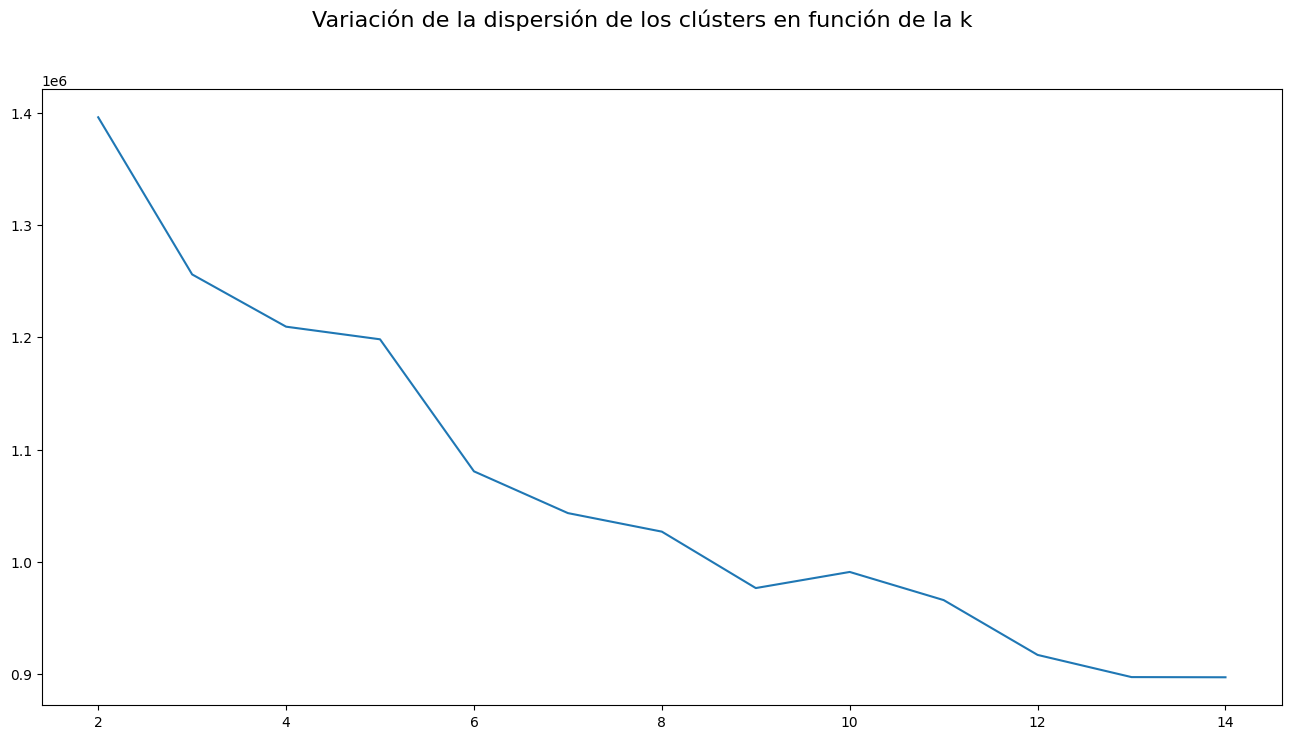

In [329]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

El codo aparece en el X, donde está el cambio más abrupto. En el Y y en el Z hay otra inflexion pero es muy leve, pero el cambio más grande es el X.
Si aparecen codos ascendentes, es raro así que solo cogeremos los codos que son descendentes.

## Segmentación de clientes con el K definido

### Filtramos el pipe con la K adecuada segun el numero de centroides

Definimos el nuevo pipe con los mismos parámetros y adadimos el clustering con la K adecuada. Ponemos random_state para que se puedan replicar los datos cada vez que se ejecuta.

In [330]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    #("CustomTransformer", ClientIdFeatureGenerator),
    #("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 3, random_state = 175)) # Definir clusters con el num de centroides
])

In [331]:
df_final.shape

(442746, 90)

In [332]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 90 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   active_customer                     442746 non-null  int64  
 1   age                                 442746 non-null  int64  
 2   salary                              442746 non-null  float64
 3   short_term_deposit                  442746 non-null  int64  
 4   loans                               442746 non-null  int64  
 5   mortgage                            442746 non-null  int64  
 6   funds                               442746 non-null  int64  
 7   securities                          442746 non-null  int64  
 8   long_term_deposit                   442746 non-null  int64  
 9   em_account_pp                       442746 non-null  int64  
 10  credit_card                         442746 non-null  int64  
 11  payroll                  

Tenemos X clientes, los que aparecen en la celde df_final.shape en el valor de X

### Hacemos un fit con el dataset final para aplicar las trasnformaciones correctas definidas en la pipe sobre el df

In [333]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('Clustering', KMeans(n_clusters=3, random_state=175))])

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados.

Hacemos el transform con el df final hasta el 2, por ejemplo

In [334]:
X_processed = pipe[:1].transform(df_final)
#X_processed = pipe.transform(df_final)

Hacemos el predict para definir las etiquetas de cadauno de los clusters.

In [335]:
labels = pipe.predict(df_final) # le hacemos las labels sobre el df_final, no sobre el escalado, ya que sino será dificil de interpretar etiquetas

In [336]:
# le asignamos el clúster al DataFrame procesado 
X_processed["cluster"] = labels

juntamos las labels con el dataset

In [337]:
X_processed.shape

(442746, 91)

## Ficha de los clientes

Tenemos quw resumir la info para describir los clusters.
Generamos el df ficha_df

In [338]:
ficha_df = pd.DataFrame()

Hacemos el resumen con el cluster al que añadimos las columnas mencionadas en el enumerate, que se añade al df de ficha final con el concat

***TENDREMOS QUE AÑADIR LAS VARIABLES NUEVAS***

In [339]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 91 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   active_customer                     442746 non-null  float64
 1   age                                 442746 non-null  float64
 2   salary                              442746 non-null  float64
 3   short_term_deposit                  442746 non-null  float64
 4   loans                               442746 non-null  float64
 5   mortgage                            442746 non-null  float64
 6   funds                               442746 non-null  float64
 7   securities                          442746 non-null  float64
 8   long_term_deposit                   442746 non-null  float64
 9   em_account_pp                       442746 non-null  float64
 10  credit_card                         442746 non-null  float64
 11  payroll                  

In [340]:
X_processed.head()

,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V,cluster
657826,1.0,44.0,54493.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
657817,0.0,32.0,-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
657986,1.0,39.0,100993.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
657905,1.0,85.0,154059.09,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
657336,1.0,38.0,-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [341]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442746 entries, 657826 to 1550586
Data columns (total 90 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   active_customer                     442746 non-null  int64  
 1   age                                 442746 non-null  int64  
 2   salary                              442746 non-null  float64
 3   short_term_deposit                  442746 non-null  int64  
 4   loans                               442746 non-null  int64  
 5   mortgage                            442746 non-null  int64  
 6   funds                               442746 non-null  int64  
 7   securities                          442746 non-null  int64  
 8   long_term_deposit                   442746 non-null  int64  
 9   em_account_pp                       442746 non-null  int64  
 10  credit_card                         442746 non-null  int64  
 11  payroll                  

In [342]:
df_final

,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V
657826,1,44,54493.38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657817,0,32,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
657986,1,39,100993.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
657905,1,85,154059.09,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
657336,1,38,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,22,43912.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1166764,0,23,23334.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1166763,1,47,-1.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1166789,0,22,199592.82,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [343]:
X_processed = X_processed.reset_index(drop = True)

In [344]:
for i, col in enumerate(["active_customer", "age", "salary", "total_products","entry_channel_KAT", "entry_channel_KFA", "entry_channel_KFC","entry_channel_KHE","entry_channel_KHK","entry_channel_KHM","entry_channel_KHN","entry_channel_KHQ","entry_channel_Others","entry_channel_RED","segment_01 - TOP","segment_02 - PARTICULARES","segment_03 - UNIVERSITARIO","segment_Not defined", "population"]): # Meter en la lista las columnas que creamos que nos describen al cliente para ver sobre los clusters en que varian y poder describirlos.
    # ['active_customer', 'entry_channel', 'total_products', ....]
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [345]:
ficha_df

cluster                                     0             1             2
active_customer            mean  4.017393e-01  4.045955e-01  3.297311e-01
                           std   4.902509e-01  4.908154e-01  4.701179e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   1.000000e+00  1.000000e+00  1.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
age                        mean  2.946040e+01  3.214518e+01  2.985370e+01
                           std   1.149568e+01  1.349483e+01  1.151980e+01
                           min   2.000000e+00  2.000000e+00  2.000000e+00
                           25%   2.200000e+01  2.300000e+01  2.200000e+01
                           50%   2.400000e+01  2.700000e+01  2.500000e+01
                           75%   3.300000e+01  3.900000e+01  3.400000e+01
                           max   1.050000e+02  1.040000e+02  1.020000e+02
salary                     mean  5.943549e+04  1.139789e+05  6.206052e+04
                           std   9.398346e+04  2.697252e+05  1.335066e+05
                           min  -1.000000e+00 -1.000000e+00 -1.000000e+00
                           25%  -1.000000e+00 -1.000000e+00 -1.000000e+00
                           50%   5.388542e+04  8.899709e+04  5.289138e+04
                           75%   9.054916e+04  1.536800e+05  8.690400e+04
                           max   1.571172e+07  2.889440e+07  1.326862e+07
total_products             mean  1.006443e+00  9.425450e-01  1.024354e+00
                           std   7.942794e-01  1.081084e+00  8.292794e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   1.000000e+00  0.000000e+00  1.000000e+00
                           50%   1.000000e+00  1.000000e+00  1.000000e+00
                           75%   1.000000e+00  1.000000e+00  1.000000e+00
                           max   8.000000e+00  9.000000e+00  8.000000e+00
entry_channel_KAT          mean  5.006967e-02  7.675256e-02  5.307708e-02
                           std   2.180893e-01  2.661994e-01  2.241884e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KFA          mean  2.075626e-03  3.097650e-02  1.953371e-03
                           std   4.551184e-02  1.732546e-01  4.415400e-02
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KFC          mean  1.152309e-01  1.662243e-01  1.233039e-01
                           std   3.193011e-01  3.722832e-01  3.287875e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KHE          mean  4.807092e-01  3.559571e-01  4.729994e-01
                           std   4.996289e-01  4.788040e-01  4.992731e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
    

Generamos indices y renombramos las variables para quea facil de entender, Generamos multiindice para visualización

In [346]:
ficha_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 133 entries, ('active_customer', 'mean') to ('population', 'max')
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       133 non-null    float64
 1   1       133 non-null    float64
 2   2       133 non-null    float64
dtypes: float64(3)
memory usage: 4.5+ KB


In [347]:
ficha_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 133 entries, ('active_customer', 'mean') to ('population', 'max')
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       133 non-null    float64
 1   1       133 non-null    float64
 2   2       133 non-null    float64
dtypes: float64(3)
memory usage: 4.5+ KB


In [348]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T

In [349]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

Grupo 0: Clientes más activos en app, media de edad de 36 años, con más productos contratados, más susceptibles a ser captados por los canales: KAT (Acceso a Tecnologías), KFA (Canal de Finanzas Avanzadas), KFC (Finanzas y Consultas por Canal), KHE (Home Banking Electrónico).
Grupo 1: Menos poder adquisitivo (por edad y salario), poco susceptibles a ser captados, pero más eficiente por los canales: KHN (Canal de Notificaciones),KHQ (Canal de HQ (High Quality) de Atención al Cliente)
Grupo 2: Mayor media de edad (48), mayor poder adquisitivo, poco activos. No susceptibles a ser captados, pero más KHK (Canal de HK (Housekeeping) Financiero), KHM (Canal de mensajería Hipotecaria). Gente establecida (no universitarios)

In [350]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

cluster,0,1,2
0,208130.000000,139396.000000,95220.000000
"('active_customer', 'mean')",0.401739,0.404596,0.329731
"('active_customer', 'std')",0.490251,0.490815,0.470118
"('active_customer', 'min')",0.000000,0.000000,0.000000
"('active_customer', '25%')",0.000000,0.000000,0.000000
"('active_customer', '50%')",0.000000,0.000000,0.000000
"('active_customer', '75%')",1.000000,1.000000,1.000000
"('active_customer', 'max')",1.000000,1.000000,1.000000
"('age', 'mean')",29.460405,32.145176,29.853697
"('age', 'std')",11.495679,13.494827,11.519803


In [351]:
ficha_df = ficha_df.rename(columns = {
    0 : "Clientes con curiosidad financiera",
    1 : "Clientes tarifa básica",
    2 : "Clientes estables y conservadores",
 })

In [352]:
ficha_df

cluster,Clientes con curiosidad financiera,Clientes tarifa básica,Clientes estables y conservadores
0,2.081300e+05,1.393960e+05,9.522000e+04
"(active_customer, mean)",4.017393e-01,4.045955e-01,3.297311e-01
"(active_customer, std)",4.902509e-01,4.908154e-01,4.701179e-01
"(active_customer, min)",0.000000e+00,0.000000e+00,0.000000e+00
"(active_customer, 25%)",0.000000e+00,0.000000e+00,0.000000e+00
"(active_customer, 50%)",0.000000e+00,0.000000e+00,0.000000e+00
"(active_customer, 75%)",1.000000e+00,1.000000e+00,1.000000e+00
"(active_customer, max)",1.000000e+00,1.000000e+00,1.000000e+00
"(age, mean)",2.946040e+01,3.214518e+01,2.985370e+01
"(age, std)",1.149568e+01,1.349483e+01,1.151980e+01


### Determinación de el cluster al que pertenecen nuestros potenciales clientes del modelo supervisado

Los clientes quedan repartidos en tres clusters definidos en el modelo (n=3). Hemos dividido entre susceptibilidad a ser captados pro canales de marketing. También vemos que los clientes suspectibles son los más activos en la aplicación y los que contratan más productos. 
Aquellos que tienen más poder adquisitivo no son activos en la aplicación y tampoco son captables por canales de marketing; son clientes más establecidos.

In [353]:
clients_clustering = X_processed.copy()

In [354]:
# Obtener el directorio de trabajo actual
current_dir = os.getcwd()

# Ir a la carpeta anterior del directorio actual porque ahí se encuentra la carpeta 'data' donde están todos los ficheros .csv
parent_dir = os.path.dirname(current_dir)

DATA_PATH = os.path.join(parent_dir, 'data/') # Ruta donde están los ficheros .csv

FILE_NAME5 = 'df_ranking.csv'
FILE5 = os.path.join(DATA_PATH, FILE_NAME5)


print('current path:', current_dir)
print('parent path:', parent_dir)
print('data path:', DATA_PATH)
print('file 5:', FILE5)

print('data path:', DATA_PATH)

current path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/clustering
parent path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/
file 5: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/df_ranking.csv
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/


In [356]:
df_ranking = pd.read_csv(FILE5, index_col=0)

In [357]:
df_ranking

""
0
1140085
1079064
1364389
1273996
1019203
...
1106680
1011510
1401434


In [358]:
df_ranking_clustered = pd.merge(
    left = df_ranking, 
    right = clients_clustering,
    left_index = True,
    right_index = True,
    how = 'inner')

In [359]:
df_ranking_clustered.shape

(1123, 91)

In [360]:
X_processed['cluster'].value_counts(normalize=True)

cluster
0    0.470089
1    0.314844
2    0.215067
Name: proportion, dtype: float64

In [361]:
df_ranking_clustered['cluster'].value_counts(normalize=True)

cluster
0    0.466607
1    0.284061
2    0.249332
Name: proportion, dtype: float64

In [362]:
df_ranking_clustered.groupby('cluster')['age'].mean()

cluster
0    29.040076
1    32.586207
2    29.460714
Name: age, dtype: float64

In [363]:
df_ranking_clustered.groupby('cluster')['salary'].mean()

cluster
0     55590.849504
1    102638.408245
2     61476.283393
Name: salary, dtype: float64

In [364]:
print(0.873603*62644)

54725.986332


Vemos que los clientes que mas probabilidad de compra tienen para el plan de pensiones, considerados en el ranking, pertenecen principalmente al cluster de clientes más susceptibles de ser captados por canales de marketing (87%).

Revisamos si en el proceso se han generado duplicados. El resultado es nulo, por lo tanto, no tenemos replicas de pk_cid.

In [365]:
# Filtrar y mostrar las filas donde el índice está duplicado
filas_duplicadas = df_ranking[df_ranking.index.duplicated(keep=False)]
print(len(filas_duplicadas))

0


In [366]:
hay_duplicados = clients_clustering.index.duplicated().any()

if hay_duplicados:
    print("El DataFrame tiene índices duplicados.")
else:
    print("El DataFrame no tiene índices duplicados.")

# Crear un nuevo DataFrame con las filas que tienen índices duplicados
df_duplicados = clients_clustering[clients_clustering.index.duplicated(keep=False)]

# Mostrar el DataFrame con índices duplicados
print(df_duplicados)

El DataFrame no tiene índices duplicados.
Empty DataFrame
Columns: [active_customer, age, salary, short_term_deposit, loans, mortgage, funds, securities, long_term_deposit, em_account_pp, credit_card, payroll, pension_plan, payroll_account, emc_account, debit_card, em_account_p, em_acount, total_products, population, entry_channel_KAT, entry_channel_KFA, entry_channel_KFC, entry_channel_KHD, entry_channel_KHE, entry_channel_KHK, entry_channel_KHM, entry_channel_KHN, entry_channel_KHQ, entry_channel_Not defined, entry_channel_Others, entry_channel_RED, segment_01 - TOP, segment_02 - PARTICULARES, segment_03 - UNIVERSITARIO, segment_Not defined, region_code_Alava, region_code_Albacete, region_code_Alicante, region_code_Almeria, region_code_Asturias, region_code_Avila, region_code_Badajoz, region_code_Barcelona, region_code_Burgos, region_code_Caceres, region_code_Cadiz, region_code_Cantabria, region_code_Castellon, region_code_Ceuta, region_code_Ciudad Real, region_code_Cordoba, region_c

In [367]:
df_duplicados


,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,...,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Vizcaya,region_code_Zamora,region_code_Zaragoza,gender_H,gender_V,cluster


In [368]:
df_ranking_clustered.to_csv('df_ranking_clustered.csv', index=False)